# Basic Diagram Examples

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2


## Imports

In [ ]:
import os
from stringdale import (
    Define,
    Scope,
    V,
    E,
    Condition,
    draw_nx
)


from stringdale.core import  checkLogs
import pytest
import asyncio


## Intro

stringdale diagrams are written as a graph of nodes and edges.

There are 3 reserved node names:
* State: a node that is used to store and access state between node executions
* Start: the start of the diagram
* End: the end of the diagram

The edges can be of three types:
* state: an edge from the State node to another node, used for either setting or getting part of the state
* conditional: edges with a possible condition which are used for deciding which node to run next
* parallel: edges that are used to run multiple nodes in parallel

Note that each node can have multiple edges coming in and out of it.
But all non state incoming edges must either be all conditional or all parallel.
The same goes for outgoing edges.

Edges can not only define the flow of the diagram, but also which part of the output of a node is passed to the input of another node.

Lets look at how to define and runa basic diagram.

## Defining ports of an edge

In [ ]:
#TODO make diagram with ** port for kwarg spread


with Define('edge_signature') as D:
    # we define the nodes with V
    # Start and End are reserved node names which are automatically added to the diagram
    # if no function is provided, the node simply passes all its inputs as a dictionary to the next node
    V('Start')
    V('End')
    # we define the edges with E
    # the edge signature is Start.output_port->End.input_port
    # this means that the output of the Start node is passed to the input of the End node
    E('Start->End(input_port = output_port)')

    # for our convenience, exiting the Define block automatically draws the diagram

# outside of the Define block,
# we can now run the diagram

# to make sure we get a fresh copy of the diagram in cases where we want have multiple instances of the same diagram
# we can use the GetDiagram function
d = D()

# with checkLogs(name='stringdale.diagrams'):
for trace in d.run({'output_port':1,'other_port':2}):
    # every node that is run will return a trace object
    # this trace object contains the input and output of the node as well as some other useful information
    # we can use this trace to both debug the diagram 
    # and also to perform other side effects such:
    # * as logging
    # * writing responses back to the user
    trace.pprint()

# we access the output of the diagram via the output property
# note that the output_port of the Start node is passed to the input_port of the End node
# the other port is discarded
d.output
assert d.output == {'input_port':1}



Node Start:
{ 'input': {'other_port': 2, 'output_port': 1},
  'output': {'other_port': 2, 'output_port': 1}}
Node End:
{'input': {'input_port': 1}, 'output': {'input_port': 1}}


## Edge types

In [ ]:
def plus(x,y):
    return x+y

# EXPLAIN start and end are by default
# with checkLogs(name='__main__'):
with Define('multiedge',type='flow') as D:

    V('plus',plus,
        inputs=[
        'Start(x=a,y=b)',
        ],
        outputs=['End']
        )
    


In [ ]:
log_file = 'log.txt'
d=D()
for trace in d.run({'a':1,'b':2}):
    trace.pprint(file=log_file)
assert d.output == 3

In [ ]:
! cat log.txt

os.unlink(log_file)

Node Start:
{'input': {'a': 1, 'b': 2}, 'output': {'a': 1, 'b': 2}}
Node plus:
{'input': {'x': 1, 'y': 2}, 'output': 3}
Node End:
{'input': {0: 3}, 'output': 3}


In [ ]:
from time import sleep

def plus1(x):
    return x+1

def plus2(x):
    return x+2

def mod2(x):
    return x%2==0


In [ ]:

with Define('naive_flow',type='flow') as NaiveFlow:

    V('plus1',plus1,inputs=['Start'],outputs=['End(x=.)'])
    V('plus2',plus2,inputs=['Start'],outputs=['End(y=.)'])
    

d = NaiveFlow()


In [ ]:
# with checkLogs(name='stringdale.diagrams.flow'):
trace_steps = []
for trace in d.run(1):
        trace.pprint()
        trace_steps.append(trace.node_name[0])

assert (trace_steps ==['Start','plus1','plus2','End'] or 
        trace_steps ==['Start','plus2','plus1','End']),trace_steps
assert d.output == {'x': 2, 'y': 3}


Node Start:
{'input': {0: 1}, 'output': 1}
Node plus1:
{'input': {0: 1}, 'output': 2}
Node plus2:
{'input': {0: 1}, 'output': 3}
Node End:
{'input': {'x': 2, 'y': 3}, 'output': {'x': 2, 'y': 3}}


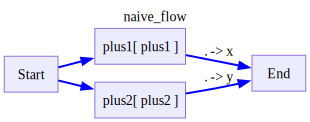

In [ ]:
with pytest.raises(ValueError,match='cannot have multiple output edges with no condition'):
    with Define('naive_flow',type='decision') as NaiveFlow:
        V('plus1',plus1,inputs=['Start'],outputs=['End(x=.)'])
        V('plus2',plus2,inputs=['Start'],outputs=['End(y=.)'])

In [ ]:
# with checkLogs(name='stringdale.diagrams.validate'):
with Define('edge_types',type='decision') as EdgeTypes:
    V('Conditional_node',plus1)
    E('Start->Conditional_node')
    V('Option1')
    V('Default_option')
    # by default, all edges we define are conditional,
    # we can specify a condition for an edge by passing a function to the cond argument
    E('Conditional_node->Option1',cond=mod2)
    # not passing a condition means that this edge is the default edge
    # each node that has outgoing conditional edges must have at least one default edge
    E('Conditional_node->Default_option')
    # we can also define a parallel edge by passing scope='parallel' to the E function
    V('Parallel_node1',plus1)
    V('Parallel_node2',plus2)
    E('Option1->Parallel_node1',type='flow')
    E('Option1->Parallel_node2',type='flow')
    E('Parallel_node1->Parallel_end(x=.)',type='flow')
    E('Parallel_node2->Parallel_end(y=.)',type='flow')
    E('Parallel_end->End(**)')
    E('Default_option->End')
    
    # we can also read and write to state by using the State node in edge definitions.
    # the port of the State node is the key of the state we would like to read from or write to
    # the port of the node we are connecting to is the value we would like to write to the state
    # if we want to read from the state, we can use the State.port notation
    E('Start->state/start')
    E('state/start->End(start_state=.)')


d = EdgeTypes()


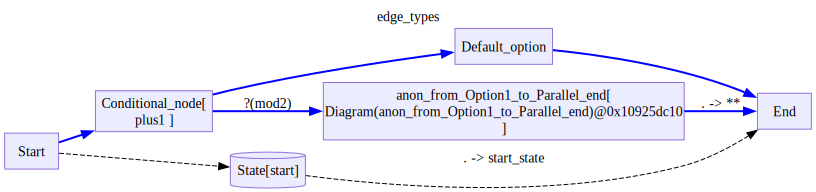

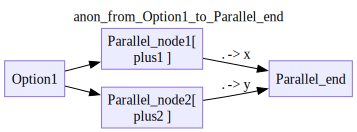

In [ ]:
d.draw(factored=True)

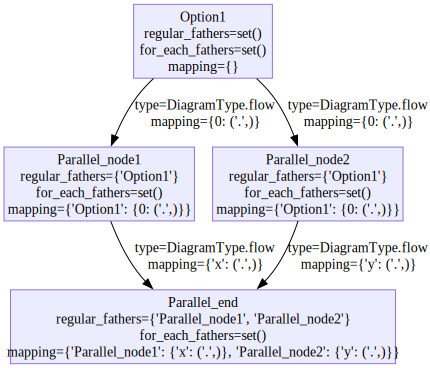

In [ ]:
draw_nx(d.funcs['anon_from_Option1_to_Parallel_end'].graph)

In [ ]:
# with checkLogs(name='stringdale.diagrams.flow'):
for trace in d.run(1):
    # trace.pprint()
    pass

assert d.output == {'x': 3, 'y': 4, 'start_state': 1} , d.output



In [ ]:
# with checkLogs(name='stringdale.diagrams'):
for trace in d.run(0):
    trace.pprint()

assert d.output == {0:1,'start_state':0}

Node Start:
{'input': {0: 0}, 'output': 0}
Node Conditional_node:
{'input': {0: 0}, 'output': 1}
Node Default_option:
{'input': {0: 1}, 'output': 1}
Node End:
{'input': {0: 1, 'start_state': 0}, 'output': {0: 1, 'start_state': 0}}


#### Custom state

In [ ]:
from stringdale.core import NamedLambda

plus1 = NamedLambda('plus1',lambda x: x+1)

from pydantic import BaseModel,ConfigDict,computed_field

# a custom state is any basemodel
class CustomState(BaseModel):
    # we can allow arbitrary attributes by setting extra='allow'
    # this is useful for defining on the fly state keys with normal behavior
    model_config = ConfigDict(extra='allow')
    history:list[int] = list()

    def save(self,value):
        self.history.append(value)

with Define('test1',state=CustomState) as D:
    V('add',plus1)
    # we can define a custom state class by passing it to the State function
    # within the Define scope
    E('Start->add')
    E('add->End')
    E('add->State/save')


In [ ]:
d=D()
for trace in d.run(input=1):
    trace.pprint()
    
assert d.output == 2
assert d.state.model_dump() == {'history': [2]},d.state
assert d.finished



Node Start:
{'input': {0: 1}, 'output': 1}
Node add:
{'input': {0: 1}, 'output': 2}
Node End:
{'input': {0: 2}, 'output': 2}


In [ ]:
def plus1(x):
    return x+1

with Define('test1_exp',state=CustomState) as D:
    V('add',plus1)
    # we can customize the state behaviour of a given state key by using the State function
    # set_append=True means that the state value will be appended to the list of values for the given key
    # we can also add custom getters and setters to a state key for more complex state behaviour
    # getter is a function of the form (value)->(processed_value)
    # setter is a function of the form (old_value,new_value)->(processed_value)
    E('Start->add')
    E('add->End')
    E('add->State/save')


In [ ]:
d=D()
for trace in d.run(input=1):
    trace.pprint()
assert d.output == 2
assert d.state.model_dump() == {'history': [2]},d.state
assert d.finished



Node Start:
{'input': {0: 1}, 'output': 1}
Node add:
{'input': {0: 1}, 'output': 2}
Node End:
{'input': {0: 2}, 'output': 2}


### Read State

In [ ]:
def plus1(x):
    return x+1

with Define('test_state_read',type='decision') as D:
    V('add',plus1,inputs=['Start'],outputs=['End(data=.)'])
    E('state/outside_state->End(state_data=.)')
    
d=D()
with checkLogs(name='stringdale.diagrstams.flow'):
    for trace in d.run(input=1,state={'outside_state':10}):
        trace.pprint()
d.output


Node Start:
{'input': {0: 1}, 'output': 1}
Node add:
{'input': {0: 1}, 'output': 2}
Node End:
{ 'input': {'data': 2, 'state_data': 10},
  'output': {'data': 2, 'state_data': 10}}


{'data': 2, 'state_data': 10}

#### Parallel graph

In [ ]:
def plus1(x,**kwargs):
    return x+1

# with checkLogs(name='__main__'):
with Define('test2',type='flow') as D:

    V('add1',plus1)
    V('add2',plus1)
    V('Start',outputs=['add1','add2'])
    V('prep_end',inputs=['add1(x=.)','add2(y=.)'])
    E('prep_end->End')


In [ ]:
d = D()
for trace in d.run(1):
    trace.pprint()

assert d.output == {'x': 2, 'y': 2}
assert d.finished

Node Start:
{'input': {0: 1}, 'output': 1}
Node add1:
{'input': {0: 1}, 'output': 2}
Node add2:
{'input': {0: 1}, 'output': 2}
Node prep_end:
{'input': {'x': 2, 'y': 2}, 'output': {'x': 2, 'y': 2}}
Node End:
{'input': {0: {'x': 2, 'y': 2}}, 'output': {'x': 2, 'y': 2}}


### Parallel with async functions

In [ ]:
async def plus1async(x,**kwargs):
    await asyncio.sleep(0.1)
    return x+1

# with checkLogs(name='__main__'):
with Define('test',type='flow') as D:

    V('add1',plus1async)
    V('add2',plus1async)
    V('Start',outputs=['add1','add2'])
    V('prepend1',inputs=['add1(x)','add2(y)'])
    E('prepend1->End')


In [ ]:
d = D()
for trace in d.run(1):
    trace.pprint()

assert d.output == {'x': 2, 'y': 2}
assert d.finished

Node Start:
{'input': {0: 1}, 'output': 1}
Node add1:
{'input': {0: 1}, 'output': 2}
Node add2:
{'input': {0: 1}, 'output': 2}
Node prepend1:
{'input': {'x': 2, 'y': 2}, 'output': {'x': 2, 'y': 2}}
Node End:
{'input': {0: {'x': 2, 'y': 2}}, 'output': {'x': 2, 'y': 2}}


#### Multiple edges from same node

In [ ]:
def plus(x,y):
    return x+y

# EXPLAIN start and end are by default
# with checkLogs(name='__main__'):
with Define('multiedge',type='flow') as D:

    V('plus',plus,
        inputs=['Start(x=a,y=b)'],
        outputs=['End']
        )

d = D()
for trace in d.run({'a':1,'b':2}):
    pass
assert d.output == 3

### Unnamed ports for discarding inputs

In [ ]:
def plus1(x):
    return x+1

# EXPLAIN start and end are by default

with Define('unnamed_ports',type='flow') as D:
    E('Start->state/start')
    V('plus',plus1,
        inputs=[
        'Start(_)',
        'state/start(x=.)'],
        outputs=['End']
        )

dot = d.draw(return_dot=True)
dot.source

'digraph multiedge {\n\tlabel=multiedge labelloc=t rankdir=LR\n\tnode_0 [label="plus[ plus ]" color="#9370DB" fillcolor="#ECECFF" shape=box style="solid,filled"]\n\tnode_1 [label=Start color="#9370DB" fillcolor="#ECECFF" shape=box style="solid,filled"]\n\tnode_2 [label=End color="#9370DB" fillcolor="#ECECFF" shape=box style="solid,filled"]\n\tnode_0 -> node_2 [color=black style=solid]\n\tnode_1 -> node_0 [label="a -> x, b -> y" color=black style=solid]\n}\n'

In [ ]:
d=D()
# with checkLogs(name='stringdale.diagrams.flow'):    
for trace in d.run(1):
    pass
assert d.output == 2


### LLM dummy functions

In [ ]:
import re
import itertools

class MessageAdder():
    def __init__(self,to_add):
        self.to_add = to_add
    
    def __call__(self,**message):
        content = message.get('content',0)
        if isinstance(content,int):
            new_cont = content + self.to_add
        elif isinstance(content,str):
            new_cont = f'{content} _ '
        else:
            raise ValueError(f'content {content} must be an int or a string')
        return {'role':'adder','content':new_cont}
    
    def __str__(self):
        return f'MessageAdder({self.to_add})'

def MessageSum(**kwargs):
    sum = 0
    for key,value in kwargs.items():
        count = value['content']
        if isinstance(count,int):
            sum+=count
    return {'role':'sum','content':sum}

class FString():
    def __init__(self,s):
        self.s=s

    def __call__(self,**kwargs):
        return self.s.format(**kwargs)

class CycleOptions():
    def __init__(self,opts):
        self.opts = opts
        self.cycle = itertools.cycle(opts)
    def __call__(self,*args,**kwargs):
        if args:
            kwargs = args[0]
        return kwargs | {'role':'chooser','choice':next(self.cycle)}
    
    def __str__(self):
        return f'''CycleOptions({",".join(self.opts)})'''

class is_mod():
    def __init__(self,mod):
        self.mod = mod

    def __call__(self, x):
        return x % self.mod == 0
    
    def __repr__(self):
        return f"is_mod({self.mod})"

class is_eq():
    def __init__(self,val):
        self.val = val

    def __call__(self, x):
        return x == self.val
    
    def __repr__(self):
        return f"is_eq({self.val})"

def concat(x,y,z):
    return (f'{x}_{y}_{z}')


    

### self loop

In [ ]:
def is3(x):
    return x['content'] == 3

with Define('selfLoop',type='decision') as D:
    V('add1',MessageAdder(1),
        inputs=['Start(**)'],
        outputs=[
            ('End(**)',is3),
            'add1(**)'
            ])


In [ ]:
d=D()
# with checkLogs(name='stringdale.diagrams'):
for i,trace in enumerate(d.run(input={'role':'human','content':0})):
    # this is how we can debug an infinite loop, have it stop after a certain number of iterations
    if i > 5: 
        break
    trace.pprint()
    
assert d.output == {'role':'adder','content': 3}
assert d.finished


Node Start:
{ 'input': {'content': 0, 'role': 'human'},
  'output': {'content': 0, 'role': 'human'}}
Node add1:
{ 'input': {'content': 0, 'role': 'human'},
  'output': {'content': 1, 'role': 'adder'}}
Node add1:
{ 'input': {'content': 1, 'role': 'adder'},
  'output': {'content': 2, 'role': 'adder'}}
Node add1:
{ 'input': {'content': 2, 'role': 'adder'},
  'output': {'content': 3, 'role': 'adder'}}
Node End:
{ 'input': {'content': 3, 'role': 'adder'},
  'output': {'content': 3, 'role': 'adder'}}


### Choosing tools

In [ ]:
#with checkLogs(name='__main__'):

def is1(x):
    return re.match('^1$',x['choice'])!=None
def is10(x):
    return re.match('^10$',x['choice'])!=None

from typing import Any,Annotated

class CustomState(BaseModel):
    model_config = ConfigDict(extra='allow')

    mem1: Annotated[list[Any],list.append] = list()

    # mem1:list[Any] = list()
    # def add_mem1(self,value):
    #     self.mem1.append(value)
    
        
with Define('choosing_tools',type='decision',state=CustomState) as D:

    E('Start->add1(**)')

    V('add1',MessageAdder(1),outputs=[
        'choose_action(**)',
        'state/mem1'
        ])
    V('add10',MessageAdder(10),outputs=[
        'choose_action(**)',
        'state/mem10'
        ])
    V('choose_action',CycleOptions(['1','10','1','10','finish']),
        outputs=[
            ('add1(**)',is1),
            ('add10(**)',is10),
            'prep_end(final_out=content)'
            ]
    )
    V('prep_end',
        inputs=[
            'State/mem1(ones=.)',
            'State/mem10(last_ten=.)',
        ],
        outputs=[
            'End'
        ]
    )# an ID step




In [ ]:
d = D()
# with checkLogs(name='stringdale.diagrams'):
for trace in d.run({'role':'human','count':0}):
    trace.pprint(skip_passthrough=True)

assert d.output == {
    'final_out': 23,
    'ones': [{'role': 'adder', 'content': 1},
            {'role': 'adder', 'content': 2},
            {'role': 'adder', 'content': 13}],
    'last_ten': {'role': 'adder', 'content': 23}
    },d.output

Node add1:
{ 'input': {'count': 0, 'role': 'human'},
  'output': {'content': 1, 'role': 'adder'}}
Node choose_action:
{ 'input': {'content': 1, 'role': 'adder'},
  'output': {'choice': '1', 'content': 1, 'role': 'chooser'}}
Node add1:
{ 'input': {'choice': '1', 'content': 1, 'role': 'chooser'},
  'output': {'content': 2, 'role': 'adder'}}
Node choose_action:
{ 'input': {'content': 2, 'role': 'adder'},
  'output': {'choice': '10', 'content': 2, 'role': 'chooser'}}
Node add10:
{ 'input': {'choice': '10', 'content': 2, 'role': 'chooser'},
  'output': {'content': 12, 'role': 'adder'}}
Node choose_action:
{ 'input': {'content': 12, 'role': 'adder'},
  'output': {'choice': '1', 'content': 12, 'role': 'chooser'}}
Node add1:
{ 'input': {'choice': '1', 'content': 12, 'role': 'chooser'},
  'output': {'content': 13, 'role': 'adder'}}
Node choose_action:
{ 'input': {'content': 13, 'role': 'adder'},
  'output': {'choice': '10', 'content': 13, 'role': 'chooser'}}
Node add10:
{ 'input': {'choice': '1

### parallel flows

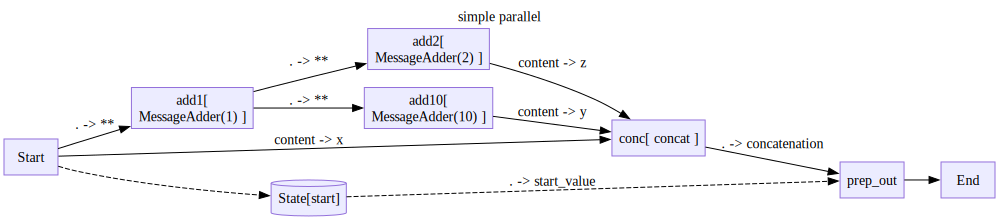

In [ ]:
with Define('simple parallel',type='flow') as D:

    V('add1',MessageAdder(1),outputs=['add2(**)','add10(**)'])
    V('add2',MessageAdder(2))
    V('add10',MessageAdder(10))
    V('conc',concat,inputs=[
        'Start(x=content)',
        'add2(z=content)',
        'add10(y=content)'
    ])
    V('prep_out',inputs=[
        'State/start(start_value)',
        'conc(concatenation)'
    ])


    E('Start->State/start')
    E('Start->add1(**)')
    E('prep_out->End')

D.draw()

In [ ]:
d = D()

# with checkLogs(name='stringdale.diagrams.flow'):
for trace in d.run({'role':'human','content':1}):
    pass

assert d.output == {'concatenation': '1_12_4', 'start_value': {'role': 'human', 'content': 1}},d.output
assert d.state.model_dump() == {'start': {'role': 'human', 'content': 1}} , d.state
d.state

BaseModelExtra(start={'role': 'human', 'content': 1})

### Parallel and choice

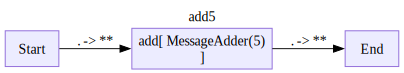

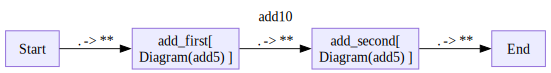

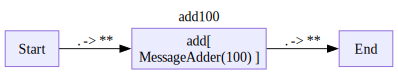

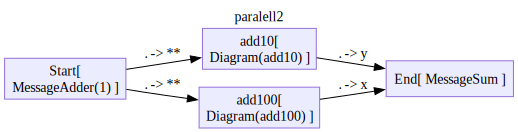

In [ ]:
with Define('add5') as Add5:
    V('add',MessageAdder(5),inputs=['Start(**)'],outputs=['End(**)'])

with Define('add10') as Add10:
    V('add_first',Add5)
    V('add_second',Add5)
    E('Start->add_first(**)')
    E('add_first->add_second(**)')
    E('add_second->End(**)')

       
with Define('add100') as Add100:
    V('add',MessageAdder(100),inputs=['Start(**)'],outputs=['End(**)'])

with Define('paralell2',type='flow') as Parallel2:

    def is112(x):
        return x['content'] == 112

    V('Start',MessageAdder(1))
    with Scope('flow'):
        V('add10',Add10,inputs=['Start(**)'])
        V('add100',Add100,inputs=['Start(**)'])
        V('End',MessageSum,inputs=['add10(y)','add100(x)'])

Add5.draw()
Add10.draw()
Add100.draw()
Parallel2.draw()

In [ ]:
d.funcs

{'add1': <__main__.MessageAdder>,
 'add2': <__main__.MessageAdder>,
 'add10': <__main__.MessageAdder>,
 'conc': <function __main__.concat(x, y, z)>}

In [ ]:
d = Parallel2()

# with checkLogs(name='stringdale.diagrams.flow'):
for trace in d.run({'role':'human','content':0}):
   trace.pprint()
       
assert d.output == {'role': 'sum', 'content': 112}

#TODO from here, how are we reseting a diagram without a graph

Node Start:
{ 'input': {'content': 0, 'role': 'human'},
  'output': {'content': 1, 'role': 'adder'}}
Node add10.Start:
{ 'input': {'content': 1, 'role': 'adder'},
  'output': {'content': 1, 'role': 'adder'}}
Node add100.Start:
{ 'input': {'content': 1, 'role': 'adder'},
  'output': {'content': 1, 'role': 'adder'}}
Node add10.add_first.Start:
{ 'input': {'content': 1, 'role': 'adder'},
  'output': {'content': 1, 'role': 'adder'}}
Node add100.add:
{ 'input': {'content': 1, 'role': 'adder'},
  'output': {'content': 101, 'role': 'adder'}}
Node add100.End:
{ 'input': {'content': 101, 'role': 'adder'},
  'output': {'content': 101, 'role': 'adder'}}
Node add10.add_first.add:
{ 'input': {'content': 1, 'role': 'adder'},
  'output': {'content': 6, 'role': 'adder'}}
Node add100:
{ 'input': {'content': 1, 'role': 'adder'},
  'output': {'content': 101, 'role': 'adder'}}
Node add10.add_first.End:
{ 'input': {'content': 6, 'role': 'adder'},
  'output': {'content': 6, 'role': 'adder'}}
Node add10.add_

In [ ]:
with Define('paralell with choice',type='decision') as D:

    def is112(x):
        return x['content'] == 112

    V('add1',MessageAdder(1),inputs=['Start(**)'])
    with Scope('flow'):
        V('add10',Add10,inputs=['add1(**)'])
        V('add100',Add100,inputs=['add1(**)'])
        V('sum',MessageSum,inputs=['add10(y)','add100(x)'])


    E('sum->End')
    E('sum->add1(**)',cond=is112)

    #EXPLAIN what are legal parallel cut

In [ ]:
d = D()
# with checkLogs(name='stringdale.diagrams'):
for trace in d.run({'role':'human','content':0}):
    # trace.pprint()
    pass
       
assert d.output == {'role': 'sum', 'content': 336}

### Overide defines

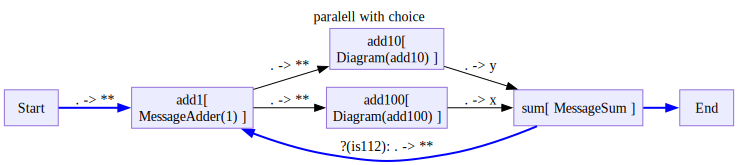

In [ ]:
D.draw()

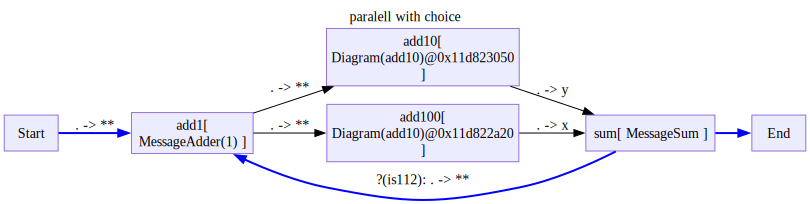

{'role': 'sum', 'content': 22}

In [ ]:
d = D(add100=Add10)
d.draw()
# TODO from here make sure we actually changed it
# TODO make sure we initialize a new diagram schema if we overide it as a define
d.run_all({'role':'human','content':0})

### Parallel with break

In [ ]:

with Define('add5') as Add5:
    V('add',MessageAdder(5),inputs=['Start(**)'],outputs=['End(**)'])

with Define('add10') as Add10:
    V('add_first',Add5)
    V('add_second',Add5)
    E('Start->add_first(**)')
    E('add_first->add_second(**)')
    E('add_second->End(**)')

       
with Define('add100') as Add100:
    V('add',MessageAdder(100),inputs=['Start(**)'],outputs=['End(**)'])

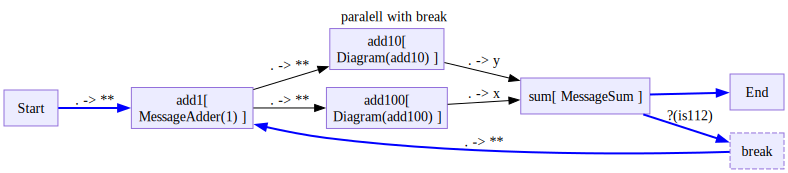

In [ ]:
# with checkLogs(name="__main__"):

with Define('paralell with break',type='decision') as D:

    def is112(x):
        return x['content'] == 112

    V('add1',MessageAdder(1),inputs=['Start(**)'])
    with Scope('flow'):
        V('add10',Add10,inputs=['add1(**)'])
        V('add100',Add100,inputs=['add1(**)'])
        V('sum',MessageSum,inputs=['add10(y)','add100(x)'])

    V('break',is_break=True)
    E('sum->End')
    E('sum->break',cond=is112)
    E('break->add1(**)')

D.draw()

In [ ]:
d = D()


output = d.run_all({'role':'human','content':0})

assert output == {'role': 'sum', 'content': 112}
assert d.finished == False

new_input = {'role':'human','content':157}
output = d.run_all(new_input)

assert output == {'role': 'sum', 'content': 426}
assert d.finished


### Nested breaks

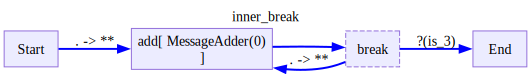

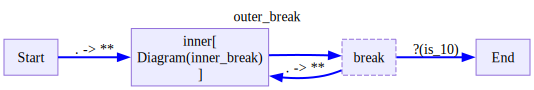

In [ ]:
def is_3(x):
    return x['content'] == 3

def is_10(x):
    return x['content'] == 10

with Define('inner_break',type='decision') as InnerD:
    V('add',MessageAdder(0),inputs=['Start(**)'],outputs=['break'])
    V('break',is_break=True,outputs=['add(**)',('End',is_3)])
    

with Define('outer_break',type='decision') as OuterD:

    V('inner',InnerD,inputs=['Start(**)'],outputs=['break'])
    V('break',is_break=True,outputs=['inner(**)',('End',is_10)])

InnerD.draw()
OuterD.draw()

what we expect to happen here, is that:
* We will enter the inner diagram, we wont exit it until we get a 3
* once we get a 3 we will exit the inerdiagram and hit the break on the outer diagram
* we will only exit the outer diagram when we get a 10

So to exit, we will need to get a 3 followed by a 10


In [ ]:
inputs = [
    {'role':'human','content':0},
    {'role':'human','content':1},
    {'role':'human','content':2},
    {'role':'human','content':3}, # exit inner the first time
    {'role':'human','content':5}, # go to outer and then to inner again
    {'role':'human','content':10}, # 10 wont get us out of the inner diagram
    {'role':'human','content':3}, # exit inner the second time
    {'role':'human','content':10}, # 10 will get us out of the outer diagram
]
outer_d = OuterD()
while True:
    input = inputs.pop(0)
    for trace in outer_d.run(input):
        print(f'{trace.node_name[0]:<16} == {trace.input_}')
    if outer_d.finished:
        break

assert outer_d.output == {'role': 'human', 'content': 10}
assert inputs == []


Start            == {'role': 'human', 'content': 0}
inner            == {'role': 'human', 'content': 0}
inner            == {'role': 'human', 'content': 0}
inner            == {'role': 'human', 'content': 1}
inner            == {'role': 'human', 'content': 1}
inner            == {'role': 'human', 'content': 2}
inner            == {'role': 'human', 'content': 2}
inner            == {'role': 'human', 'content': 3}
inner            == {0: {'role': 'human', 'content': 3}}
inner            == {'role': 'human', 'content': 3}
break            == {'role': 'human', 'content': 5}
inner            == {'role': 'human', 'content': 5}
inner            == {'role': 'human', 'content': 5}
inner            == {'role': 'human', 'content': 10}
inner            == {'role': 'human', 'content': 10}
inner            == {'role': 'human', 'content': 3}
inner            == {0: {'role': 'human', 'content': 3}}
inner            == {'role': 'human', 'content': 3}
break            == {'role': 'human', 'content': 10}

### Cant break inside parallel

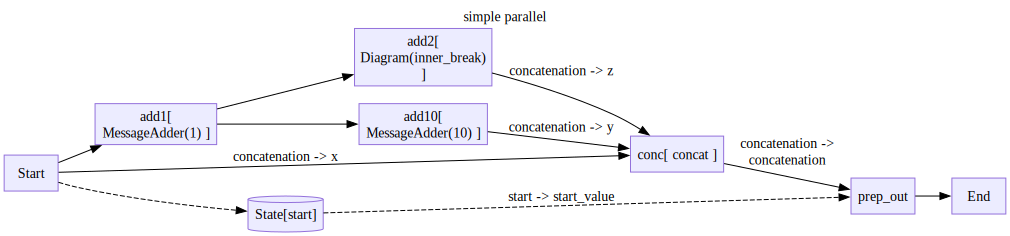

In [ ]:
with pytest.raises(ValueError,match='Breakpoints are not allowed in a Flow diagram'):
    with Define('simple parallel',type='flow') as d:

        V('add1',MessageAdder(1))
        V('add2',InnerD)
        V('add10',MessageAdder(10))
        V('conc',concat)
        V('prep_out')


        E('Start->State/start')
        E('Start->conc(x=concatenation)')
        E('Start->add1')
        E('add1->add10')
        E('add1->add2')
        E('add10->conc(y=concatenation)')
        E('add2->conc(z=concatenation)')
        E('conc->prep_out(concatenation=concatenation)')
        E('State/start->prep_out(start_value=start)')
        E('prep_out->End')


### Far ancestor writing to state


In [ ]:
from itertools import pairwise

In [ ]:
class CustomState(BaseModel):
    model_config = ConfigDict(extra='allow')

    history: Annotated[list[Any],list.append] = list()

with Define('far ancestor writing to state',type='flow',state=CustomState) as D:
    a = MessageAdder(0)

    for u in ['a','b','c']:
        V(u,a)
        E(f'{u}->state/history')

    for u,v in pairwise(['Start','a','b','c','End']):
        E(f'{u}->{v}(**)')
    


In [ ]:
# with checkLogs(name='__main__'):
d=D()
for trace in d.run({'role':'human','content':0}):
    pass
assert d.state.model_dump() == {'history': [{'role': 'adder', 'content': 0},
                               {'role': 'adder', 'content': 0},
                               {'role': 'adder', 'content': 0}]} 

### Initialising state

In [ ]:
def plus(x,y):
    return x+y

with Define('init_state_no_clash',type='decision') as NoClash:
    
    V('add1',plus,
        inputs=['Start(x)','State/init(y)'],
        outputs=['State/first_sum']
        )

    V('break',is_break=True,inputs=['add1(x)'])

    V('add2',plus,
        inputs=['break(x)','State/first_sum(y)'],
        outputs=['End']
        )

In [ ]:
inputs = [
    10,
    100
]

outputs = []
d=NoClash()
while True:
    # note that the init state is preserved between runs
    for trace in d.run(input=inputs.pop(0),state={'init':1000}):
        pass
    outputs.append(d.output)
    if d.finished:
        break

assert outputs == [1010,1110],outputs


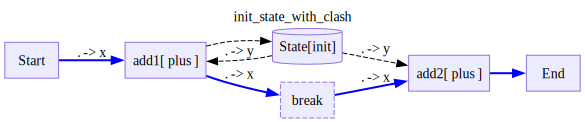

In [ ]:
def plus(x,y):
    return x+y

class StateRequiresInit(BaseModel):
    init : int

with Define('init_state_with_clash',type='decision',state=StateRequiresInit) as D:
    
    V('add1',plus,
        inputs=['Start(x)','State/init(y)'],
        outputs=['State/init']
        )

    V('break',is_break=True,inputs=['add1(x)'])

    V('add2',plus,
        inputs=['break(x)','State/init(y)'],
        outputs=['End']
        )
D.draw()

In [ ]:
inputs = [
    10,
    100
]
outputs = []
d=D()
while True:
    # note that the internal state overides the state given to the run method
    # that is why after the breakpoint, state.init is 1010 and not 1000
    for trace in d.run(input=inputs.pop(0),state={'init':1000}):
        pass
    outputs.append(d.output)
    if d.finished:
        break

assert outputs == [1010,1110],outputs


In [ ]:
d.state

StateRequiresInit(init=1010)

In [ ]:
# make sure that two calls to the Same D dont share state
d=D()
outputs = []

for trace in d.run(input=10,state={'init':1000}):
    pass
outputs.append(d.output)

for trace in d.run(input=100):
    pass
outputs.append(d.output)


assert d.finished
assert outputs == [1010,1110],outputs


### Missing input state

In [ ]:
d = NoClash()
with pytest.raises(AttributeError,match='''object has no attribute '''):
# # with checkLogs(name='stringdale.diagrams'):
    for trace in d.run(input=10):
        pass


## Stateful nodes and Serialization

In [ ]:
class MessageCounter():
    def __init__(self):
        self.history = []
    def __call__(self,message):
        self.history.append(message['content'])
        return {'role':'counter','content':str(self.history)}
    def __str__(self):
        return f'MessageCounter({self.history})'

    def __repr__(self):
        return f'<at #{id(self)}>{self.__str__()}'

    def reset(self):
        self.history = []

    def dump_state(self):
        return self.history

    def load_state(self,state_object):
        self.history = state_object


In [ ]:
class CustomState(BaseModel):
    timer:int
    counter_outputs: Annotated[list[Any],list.append] = list()

    def count_down(self,value):
        self.timer = max(0,self.timer-1)
        return self.timer

def is_timeout(x):
    return x['timer'] == 'TimerOut'

with Define('stateful_adder',type='decision',state=CustomState) as StateFulAdder:
    V('router',
        inputs=['Start(message)','state/timer(timer)'],
        outputs=['adder(message=message)']
        )
    E('router->End',cond=is_timeout)
    V('adder',MessageCounter(),
        outputs=['state/counter_outputs','state/count_down'])
    V('break',is_break=True,inputs=['adder'],outputs=['router(message)'])
    
    


In [ ]:
# make 2 copies of the diagram
copy1 = StateFulAdder()
copy2 = StateFulAdder()

# run copy1
for trace in copy1.run({'role':'human','content':1},state={'timer':4}):
    pass
assert copy1.output == {'role':'counter','content':'[1]'},copy1.output
assert copy1.finished == False

# make sure copy2 didnt change
assert copy2.finished == None
assert copy2.state == None


# load the state from copy1 into copy2
saved_state = copy1.dump_state()
copy2.load_state(saved_state)

# check copy2 has the same output as copy1
assert copy2.output == copy1.output
assert copy2.finished == copy1.finished


# Continue copy1 and copy2 with different inputs
# note that we dont need to pass the state again, it is preserved from the copy1 run

res1 = copy1.run_all({'role':'human','content':2})
res2 = copy2.run_all({'role':'human','content':3})


# make sure we got different outputs
assert res1 == {'role': 'counter', 'content': '[1, 2]'}, res1
assert res2 == {'role': 'counter', 'content': '[1, 3]'}, res2

## Conflicting ports

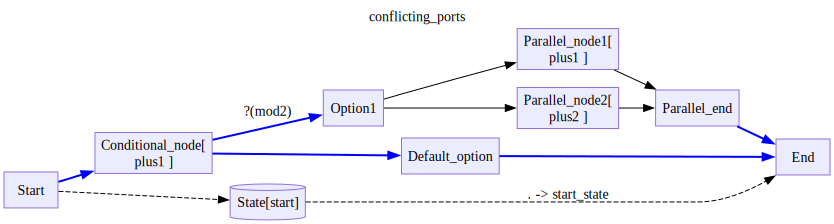

Node Parallel_end has conflicting input ports '[0]'
between its father nodes and/or state {'input_state_ports': [], 'Parallel_node1': [0], 'Parallel_node2': [0]}


In [ ]:
with pytest.raises(ValueError,match='has conflicting input ports') as e:
    with Define('conflicting_ports',type='decision') as d:
        V('Conditional_node',plus1)
        E('Start->Conditional_node')
        V('Option1')
        V('Default_option')
        # by default, all edges we define are conditional,
        # we can specify a condition for an edge by passing a function to the cond argument
        E('Conditional_node->Option1',cond=mod2)
        # not passing a condition means that this edge is the default edge
        # each node that has outgoing conditional edges must have at least one default edge
        E('Conditional_node->Default_option')
        # we can also define a flow edge by passing scope='flow' to the E function
        V('Parallel_node1',plus1)
        V('Parallel_node2',plus2)
        E('Option1->Parallel_node1',type='flow')
        E('Option1->Parallel_node2',type='flow')
        E('Parallel_node1->Parallel_end',type='flow')
        E('Parallel_node2->Parallel_end',type='flow')
        E('Parallel_end->End')
        E('Default_option->End')
        
        # we can also read and write to state by using the State node in edge definitions.
        # the port of the State node is the key of the state we would like to read from or write to
        # the port of the node we are connecting to is the value we would like to write to the state
        # if we want to read from the state, we can use the State.port notation
        E('Start->State/start')
        E('State/start->End(start_state)')


print(e.value.args[0])


## Exception during condition

In [ ]:
with Define('selfLoop',type='decision') as D:

    def is12(x):
        return x['content'] == 12
    def istoobig(x):
        return x['shmontest'] > 12
    def zeroup (x):
        x['content'] = 0
        return x
    V('too_big')
    V('adder',MessageAdder(4),
        inputs=['Start(**)','too_big(**)'],
        outputs=[
            ('End',is12),
            ('too_big(**)',istoobig),
            'adder(**)'
            ])
    V('too_big',zeroup)
d=D()
with pytest.raises(ValueError,match='When choosing next node after adder') as e:
    for i,trace in enumerate(d.run(input={'role':'human','content':0})):
        pass
    
print(e.value.args[0])
    

When choosing next node after adder:
Condition function <function istoobig>({'role': 'adder', 'content': 4}) returned 
KeyError:''shmontest''


### defining conditional edges after node definition

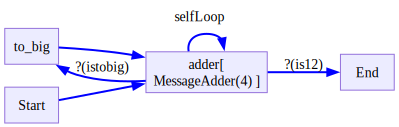

When adding edge 'to_big->adder' with condition <function <lambda>>, type None and edge_data {'edge_type': 'edge', 'mapping': {0: ('.',)}}
Edge to_big->adder already exists, edge: to_big->adder



In [ ]:
with pytest.raises(ValueError,match='Edge to_big->adder already exists') as e:
    with Define('selfLoop',type='decision') as D:

        def is12(x):
            return x['content'] == 12
        def istobig(x):
            return x['content'] > 12
        def zeroup (x):
            return {0: ('adder', 0)}
        V('to_big')
        V('adder',MessageAdder(4),
            inputs=['Start','to_big'],
            outputs=[
                ('End',is12),
                ('to_big',istobig),
                'adder'
                ])
        E('to_big->adder', lambda x: zeroup(x['content']))

print(e.value.args[0])

## Batch processing

Regular batch processing

In [ ]:
import time
import asyncio

class MakeItems:
    def __init__(self,num_items,delta,sleep):
        self.num_items = num_items
        self.delta = delta
        self.sleep = sleep
    def __call__(self,x):
        time.sleep(self.sleep)
        return [x+i*self.delta for i in range(self.num_items)]

    def __str__(self):
        return f'MakeItems(num_items={self.num_items},delta={self.delta},sleep={self.sleep})'

class MakeItemsAsync:
    def __init__(self,num_items,delta,sleep):
        self.num_items = num_items
        self.delta = delta
        self.sleep = sleep
    async def __call__(self,x):
        await asyncio.sleep(self.sleep)
        return [x+i*self.delta for i in range(self.num_items)]
    def __str__(self):
        return f'MakeItemsAsync(num_items={self.num_items},delta={self.delta},sleep={self.sleep})'


def add_to_arr(arr,x):
    return [a+x for a in arr]

def plus(x,y):
    return x+y

def sort(arr):
    return sorted(arr)

async def asort(arr):
    return sorted(arr)


In [ ]:
with Define('batch_processing_sync',type='flow') as D:
    V('make_items',MakeItems(3,delta = 1,sleep = 0.1),inputs=['Start'])
    V('more_items',MakeItems(3,delta = 10,sleep = 0.1),
        for_each=['x'],
        inputs=['make_items(x)'],
        outputs=['End'], flat=True
        )
    V('End',sort)


In [ ]:
# with  checkLogs(name='stringdale.diagrams.flow'):
d=D()
for trace in d.run(0):
    trace.pprint()

assert d.output == [0, 1, 2, 10, 11, 12, 20, 21, 22]

Node Start:
{'input': {0: 0}, 'output': 0}
Node make_items:
{'input': {0: 0}, 'output': [0, 1, 2]}
Node more_items[0]:
{'input': {'x': 0}, 'output': [0, 10, 20]}
Node more_items[1]:
{'input': {'x': 1}, 'output': [1, 11, 21]}
Node more_items[2]:
{'input': {'x': 2}, 'output': [2, 12, 22]}
Node End:
{ 'input': {0: [0, 10, 20, 1, 11, 21, 2, 12, 22]},
  'output': [0, 1, 2, 10, 11, 12, 20, 21, 22]}


### Batch processing with async functions

In [ ]:
with Define('batch_processing_async',type='flow') as D:
    V('make_items',MakeItemsAsync(3,delta = 1,sleep = 0.1),inputs=['Start'])
    V('more_items',MakeItemsAsync(3,delta = 10,sleep = 0.1),
        for_each=['x'],
        inputs=['make_items(x)'],
        outputs=['End'], flat=True
        )
    V('End',asort)


In [ ]:
# with  checkLogs(name='stringdale.diagrams.flow'):
d=D()
for trace in d.run(0):
    trace.pprint()

assert d.output == [0, 1, 2, 10, 11, 12, 20, 21, 22]


Node Start:
{'input': {0: 0}, 'output': 0}
Node make_items:
{'input': {0: 0}, 'output': [0, 1, 2]}
Node more_items[2]:
{'input': {'x': 2}, 'output': [2, 12, 22]}
Node more_items[0]:
{'input': {'x': 0}, 'output': [0, 10, 20]}
Node more_items[1]:
{'input': {'x': 1}, 'output': [1, 11, 21]}
Node End:
{ 'input': {0: [2, 12, 22, 0, 10, 20, 1, 11, 21]},
  'output': [0, 1, 2, 10, 11, 12, 20, 21, 22]}


In [ ]:
import time
import asyncio

class MakeItems:
    def __init__(self,num_items,delta,sleep):
        self.num_items = num_items
        self.delta = delta
        self.sleep = sleep
    def __call__(self,x):
        time.sleep(self.sleep)
        return [x+i*self.delta for i in range(self.num_items)]

    def __str__(self):
        return f'MakeItems(num_items={self.num_items},delta={self.delta},sleep={self.sleep})'

class MakeItemsAsync:
    def __init__(self,num_items,delta,sleep):
        self.num_items = num_items
        self.delta = delta
        self.sleep = sleep
    async def __call__(self,x):
        await asyncio.sleep(self.sleep)
        return [x+i*self.delta for i in range(self.num_items)]
    def __str__(self):
        return f'MakeItemsAsync(num_items={self.num_items},delta={self.delta},sleep={self.sleep})'


def sum_all(*arr):
    return sum(arr)

def add_to_arr(arr,x):
    return [a+x for a in arr]

def plus(x,y):
    return x+y

def sort(arr):
    return sorted(arr)

async def asort(arr):
    return sorted(arr)

def concat(arr1,arr2):
    return arr1+arr2


### Cartesian product of input streams

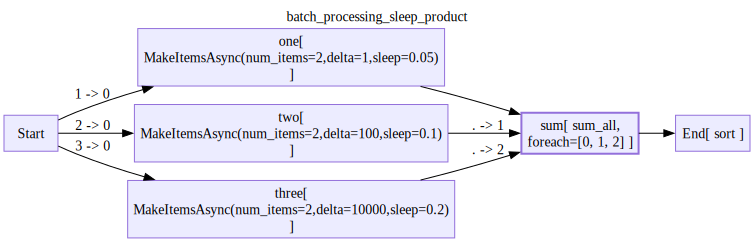

In [ ]:
with Define('batch_processing_sleep_product',type='flow') as D:
    V('one',MakeItemsAsync(2,1,sleep=0.05),inputs=['Start(0=1)'])
    V('two',MakeItemsAsync(2,100,sleep=0.10),inputs=['Start(0=2)'])
    V('three',MakeItemsAsync(2,10000,sleep=0.2),inputs=['Start(0=3)'])
    V('sum',sum_all,inputs=['one(0)','two(1)','three(2)'],for_each=[0,1,2])
    V('End',sort,inputs=['sum'])
D.draw()

In [ ]:
d=D()
for trace in d.run({1:10,2:1000,3:100000}):
    # trace.pprint()
    pass

assert d.output == [101010, 101011, 101110, 101111, 111010, 111011, 111110, 111111]

## Using for_each with both stream and non stream inputs

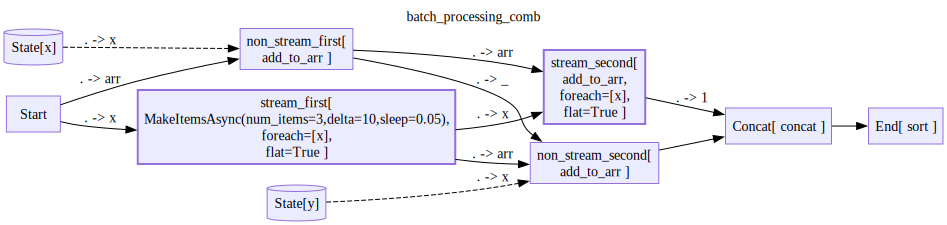

In [ ]:
with Define('batch_processing_comb',type='flow') as D:
    V('non_stream_first',add_to_arr,inputs=['Start(arr)','State/x(x)'])
    V('stream_first',MakeItemsAsync(3,10,sleep=0.05),inputs=['Start(x)'],for_each=['x'],flat=True)

    V('non_stream_second',add_to_arr,inputs=['non_stream_first(_)','stream_first(arr)','State/y(x)'])
    V('stream_second',add_to_arr,inputs=['stream_first(x)','non_stream_first(arr)'],for_each=['x'],flat=True)

    V('Concat',concat,inputs=['non_stream_second(0)','stream_second(1)'])
    V('End',sort,inputs=['Concat'])

D.draw()

In [ ]:
# with checkLogs(name='stringdale.diagrams.flow'):
d=D()
for trace in d.run([0],state={'x':100,'y':1000}):
    trace.pprint()

assert d.output == [100, 110, 120, 1000, 1010, 1020]

Node Start:
{'input': {0: [0]}, 'output': [0]}
Node non_stream_first:
{'input': {'arr': [0], 'x': 100}, 'output': [100]}
Node stream_first[0]:
{'input': {'x': 0}, 'output': [0, 10, 20]}
Node non_stream_second:
{'input': {'arr': [0, 10, 20], 'x': 1000}, 'output': [1000, 1010, 1020]}
Node stream_second[1]:
{'input': {'arr': [100], 'x': 10}, 'output': [110]}
Node stream_second[0]:
{'input': {'arr': [100], 'x': 0}, 'output': [100]}
Node stream_second[2]:
{'input': {'arr': [100], 'x': 20}, 'output': [120]}
Node Concat:
{ 'input': {0: [1000, 1010, 1020], 1: [110, 100, 120]},
  'output': [1000, 1010, 1020, 110, 100, 120]}
Node End:
{ 'input': {0: [1000, 1010, 1020, 110, 100, 120]},
  'output': [100, 110, 120, 1000, 1010, 1020]}


## Nested diagrams in foreach

In [ ]:
async def add_sleep(x):
    await asyncio.sleep(0.1)
    return x+1


In [ ]:
with Define('async_adder')as AsyncAdd:
    V('add',add_sleep,inputs=['Start(x=x)'],outputs=['End'])

async_add=AsyncAdd()
for trace in async_add.run({'x':0}):
    trace.pprint()


Node Start:
{'input': {'x': 0}, 'output': {'x': 0}}
Node add:
{'input': {'x': 0}, 'output': 1}
Node End:
{'input': {0: 1}, 'output': 1}


In [ ]:

with Define('nested_foreach',type='flow') as D:
    V('generate',MakeItemsAsync(3,10,sleep=0.05),inputs=['Start(**)'])
    V('add',AsyncAdd,inputs=['generate(x=.)'],for_each=['x'])
    V('End',sort,inputs=['add'])


In [ ]:
d=D()
for trace in d.run({'x':0}):
    trace.pprint()
assert d.output == [1, 11, 21]

Node Start:
{'input': {'x': 0}, 'output': {'x': 0}}
Node generate:
{'input': {'x': 0}, 'output': [0, 10, 20]}
Node add[0].Start:
{'input': {'x': 0}, 'output': {'x': 0}}
Node add[2].Start:
{'input': {'x': 20}, 'output': {'x': 20}}
Node add[1].Start:
{'input': {'x': 10}, 'output': {'x': 10}}
Node add[2].add:
{'input': {'x': 20}, 'output': 21}
Node add[0].add:
{'input': {'x': 0}, 'output': 1}
Node add[1].add:
{'input': {'x': 10}, 'output': 11}
Node add[0].End:
{'input': {0: 1}, 'output': 1}
Node add[2].End:
{'input': {0: 21}, 'output': 21}
Node add[1].End:
{'input': {0: 11}, 'output': 11}
Node add[1]:
{'input': {'x': 10}, 'output': 11}
Node add[2]:
{'input': {'x': 20}, 'output': 21}
Node add[0]:
{'input': {'x': 0}, 'output': 1}
Node End:
{'input': {0: [11, 21, 1]}, 'output': [1, 11, 21]}


## Text splitting

In [ ]:
sample_doc = {'text':"""
The elephant is one of the most remarkable creatures on Earth. Known for their intelligence and complex social structures, elephants form deep family bonds that can last a lifetime. These gentle giants possess remarkable memory capabilities and demonstrate emotional behaviors like mourning their dead. Their distinctive trunks, containing over 40,000 muscles, serve multiple purposes from gathering food to expressing affection.

The arctic fox is a fascinating animal that has adapted perfectly to life in the extreme cold. During winter, its thick white fur provides both insulation and camouflage in the snowy landscape, while in summer its coat turns brownish-gray to blend with the tundra. These resourceful predators can survive temperatures as low as -50°C (-58°F) and will travel vast distances across the Arctic ice in search of food, often following polar bears to scavenge their leftovers.

The octopus stands out as one of the ocean's most intelligent invertebrates. With nine brains (one central brain and eight additional ones in each arm), these cephalopods can solve complex puzzles, open jars, and even use tools. Their remarkable ability to change both color and texture allows them to perfectly mimic their surroundings, making them masters of disguise. Despite their impressive capabilities, most octopus species live only 1-2 years, making their intelligence even more remarkable given their short lifespan.
""",
'id':'animal_book'
}


def splitter(doc):
    doc_id = doc['id']
    text = doc['text']
    return [{'text':chunk.strip(),'id':f'{doc_id}_{i}'} for i,chunk in enumerate(text.split('\n\n'))]


def summarizer(text):
    return text[:20]


In [ ]:
with Define('Distilation Rag Uploader',type='flow') as D:
    V('split_texts',splitter,inputs=['Start(doc=.)'],for_each=['doc'],flat=True)
    V('summarize_texts',summarizer,inputs=['split_texts(text=text)'],for_each=['text'])
    V('End',sort,inputs=['summarize_texts'])


In [ ]:
d = D()
for trace in d.run([sample_doc]):
    # trace.pprint()
    pass

assert d.output == ['The arctic fox is a ', 'The elephant is one ', 'The octopus stands o'],d.output

## Export

In [ ]:

# TODO
# for trace in d.run({'pdfs':['path/to/pdf.pdf','path/to/pdf2.pdf']}):
#     # TODO make pprint to log
#     # make progress bars for parallel pipelines with multiple items
#         # see this https://stackoverflow.com/a/78127892
#     trace.to_logger()


#TODO make sure nested objects in the input,output are also pprinted (ie data classes with alot of field)

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()